<p style="font-family:Times;font-size:250%; text-align:center"> <font color='red'>Stochastic Gradient Descent (SGD)</font></p>

<p style="font-family:Times;font-size:200%; text-align:center"> <font color='red'>Dengan Adam Optimizer</font></p>

___



In [3]:
from numpy import *   
import numpy as np
from numpy.random import *
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

np.set_printoptions(precision = 3, suppress = True, formatter = {'float':'{:5.4f}'.format})

#Sigmoid function & its derivative
sigmoid = lambda Z: 1/(1+exp(-Z))
dsigmoid = lambda A: A*(1-A)

#ReLU function & its derivative
ReLU  = lambda Z: Z.clip(0)
#Derivative of ReLU function
dReLU = lambda A: (A > 0)*1

#Derivativer of tanh()
dtanh = lambda A: 1-A**2

#Derivative oh arctanh
darctanh = lambda A: 1/(A**2+1)

#Softplus function & its derivative
splus = lambda Z: log(1+exp(Z))
dsplus = lambda A: 1/(1+exp(-A))

linear = lambda X,w,b: X@w+b

"Time step (ts)"
def steps(x, step):   
    obs  = len(x)-step
    xt   = x[:obs,:]
    for i in arange(1,step+1):
        xt = hstack((xt, x[i:obs+i,:]))   
    return xt

In [16]:
class NeuralNetwork:
    
    def __init__(self,x,y,hlayers,alpha,mbs): # ada h nodes di dalam hidden layer  hlayers = [7, 3, 34, 89]
        self.X  = x   #input
        self.y  = y   #output
        self.hlayers = hlayers   #note: untuk model Perceptron gunakan hlayers = []
        self.alpha  = alpha
        self.mbs = mbs
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8
        self.t = 0
        
        #self.Xt = x   #akan digunakan untuk SGD
        #self.yt = y   #akan digunakisn di SGD
        
        assert ndim(y)            == 2     #y harus berupa matriks (berdimensi 2)
        assert type(self.hlayers) == list  #hlayers harus berupa sebuah list
        
        self.N, ni = shape(x)   #jumlah features (variables)
        self.N, no = shape(y)   #jumlah observasi (self.N) dan jumlah output (no)
        
        self.neurons = [ni]
        self.neurons.extend(self.hlayers)
        self.neurons.append(no)   #jumlah neurons per layer, termasuk input layer 
        self.nlayers  = len(self.neurons)-1  #number of layers (tidak termasuk input layer)

        "Initial values untuk parameter w and b"

        self.w, self.b = [], []
        self.Vw, self.Vb = [], []
        self.m_dw, self.m_db, self.v_dw, self.v_db = [], [], [], []
        for i in arange(self.nlayers):
            self.w.append(randn(self.neurons[i], self.neurons[i+1]))  #Sinapsis dari layer ke i menuju layer ke (i+1)  
            self.b.append(randn(1, self.neurons[i+1]))           #Bias di layer ke (i+1)    
   
            self.Vw.append(randn(self.neurons[i], self.neurons[i+1]))  
            self.Vb.append(randn(1, self.neurons[i+1]))  
            
            self.m_dw.append(zeros([self.neurons[i], self.neurons[i+1]]))  
            self.m_db.append(zeros([1, self.neurons[i+1]]))  
            
            self.v_dw.append(zeros([self.neurons[i], self.neurons[i+1]]))  
            self.v_db.append(zeros([1, self.neurons[i+1]]))

    def training(self):
        
        acak  = choice(len(self.y), int(self.mbs*len(self.y)), replace = False)   #bikin indeks pengambilan secara acak sebesar bs
        Xmini = self.X[acak]   #mini batch sample dari X
        ymini = self.y[acak]   #mini batch sample dari y
        
        
        for Xt,yt in zip(Xmini,ymini):
            self.t = self.t + 1
            "Forward propagation (perambatan maju)"
    
            Z, A = [], [Xt]
        
            "Dimulai dari Hidden layers"
            for j in arange(len(hlayers)):   #hanya hidden layers
                Z.append(linear(A[j], self.w[j], self.b[j]))  #Reaksi kimia di layer ke (j + 1)
                A.append(tanh(Z[j]))     #Aliran listrik di layer ke (j + 1)
        
            "Output layer"
            Z.append(linear(A[self.nlayers-1], self.w[self.nlayers-1], self.b[self.nlayers-1]))  #Reaksi kimia di output layer
            A.append(sigmoid(Z[self.nlayers-1]))
    
            self.predicted_yt = A[self.nlayers]
            e         = yt-self.predicted_yt

            "Backward propagation (perambatan mundur)"
        
            
            "Dimulai dari output layer"
            dCdZ = [(-2*e/len(yt))*dsigmoid(A[::-1][0])]  #berbentuk list agar bisa di-append, mulai dari output layer
            
#             beta = 0.1   #0.02
            "Hidden layer"                                           
            for m in arange(self.nlayers-1):  #dan mundur ke layer berikutnya, sampai hidden layer pertama
                dCdZ.append((dCdZ[m]@(self.w[::-1][m]-self.Vw[::-1][m]).T)*dtanh(A[::-1][m+1]))   #delta
        
            "Perubahan parameters (w dan b):"
    
            one  = ones([1,len(yt)])
            dCdw, dCdb = [], []   #dalam bentuk list agar bisa di-append
            
            
            for n in arange(self.nlayers): 
                
                "Algoritma Stochatic Gradient descents"
                
                dCdw.append( A[n].T @ dCdZ[::-1][n] )  #Dapatkan gradients untuk w dari dCdZ
                dCdb.append( one @ dCdZ[::-1][n] )     #Dapatkan gradients untuk b dari dCdZ
                
                "Adam Optimizer"

                self.m_dw[n] = self.beta1*self.m_dw[n] + (1 - self.beta1) * dCdw[n]
                self.v_dw[n] = self.beta2*self.v_dw[n] + (1 - self.beta2) * dCdw[n]**2
                
                self.m_db[n] = self.beta1*self.m_db[n] + (1 - self.beta1) * dCdb[n]
                self.v_db[n] = self.beta2*self.v_db[n] + (1 - self.beta2) * dCdb[n]**2
                
                m_dw_bias_corr = self.m_dw[n] / (1 - self.beta1**self.t)
                v_dw_bias_corr = self.v_dw[n] / (1 - self.beta2**self.t)
                
                m_db_bias_corr = self.m_db[n] / (1 - self.beta1**self.t)
                v_db_bias_corr = self.v_db[n] / (1 - self.beta2**self.t)
                
                self.Vw[n] = self.alpha * m_dw_bias_corr / (sqrt(v_dw_bias_corr) + self.epsilon)
                self.Vb[n] = self.alpha * v_db_bias_corr / (sqrt(v_db_bias_corr) + self.epsilon)
                
                self.w[n] = self.w[n] - self.Vw[n] #Parameter w di-update 
                self.b[n] = self.b[n] - self.Vb[n] #Parameter b di-update 
    
    
    def prediction(self, Xs, ys):   #Gunakan data secara keseluruhan
        
        "Forward propagation (perambatan maju)"
    
        Z, A = [], [Xs]
        
        "Dimulai dari Hidden layers"
        for j in arange(len(hlayers)):   #hanya hidden layers
            Z.append(linear(A[j],self.w[j],self.b[j]))  #Reaksi kimia di layer ke (j + 1)
            A.append(tanh(Z[j]))     #Aliran listrik di layer ke (j + 1)
        
        "Output layer"
        Z.append(linear(A[self.nlayers-1],self.w[self.nlayers-1],self.b[self.nlayers-1]))  #Reaksi kimia di output layer
        A.append(sigmoid(Z[self.nlayers-1]))
    
        self.predicted_y = A[self.nlayers]
        e         = ys-self.predicted_y
        self.Cost = e.T@e/len(ys)  #mean squared error

#### Contoh: Prediksi harga saham Hawlett-Packard Enterprise (HPE)

In [44]:
A  = pd.read_csv('HPE.csv')  #Data time series harian harga saham HPE
A6 = A['Adj Close'].values   #Ambil kolom ke enam berisi 'Adj Close', 
B  = A6[:,newaxis]  #berupa matriks
                                     
Bmin = min(B)
Bmax = max(B)
b = (B-Bmin)/(Bmax-Bmin)

ts = 1   #Di literatur Time Series digunakan istilah 'lag' sebagai padanan istilah 'timestep' ini
xt = steps(b, ts)  #Dihasilkan matriks dengan 2 (= ts+1) kolom, kolom pertama menjadi variabel X
                   #dan kolom terkhir menjadi variabel y

x = xt[:,:]    #Ambil semua data

#Data untuk training
Xtrain = x[0:900, :-1]   #Ambil 680 observasi yang pertama dan hilangkan kolom terakhir
ytrain = x[0:900:, -1:]  #Ambil 680 observasi yang pertama dan ambil kolom terakhir sebagai variabel y 

#Data untuk testing
Xtest = x[900:, :-1]   #ambil jumlah observasi sebanyak 120, hilangkan kolom terakhir (untuk y)
ytest = x[900:, -1:]   #ambil kolom terakhir

hlayers = [3, 2]  #Dua hidden layers, masing-masing dengan 3 neurons dan 2 neurons
alpha   = 0.001
mbs     = 0.15  #hanya 15% dari seluruh observasi yang digunakan untuk penaksiran parameter
epochs  = 400

#Rangkuman activation function di hidden layers & output layer

#tanh & sigmoid:
#SGD dengan Momentum: mbs = 0.15, alpha = 0.65, beta = 0.1, epochs = 400 initial values di luar epochs
#SGD : mbs = 1,    alpha = 0.17,  epochs = 70, 
#MBGD: mbs = 0.15, alpha = 0.165, epochs = 400, alpha = 0.27, epochs = 1600
#      mbs = 0.20, alpha = 0.165, epochs = 450

tic = datetime.now()

seed(20200219)

ann2 = NeuralNetwork(Xtrain,ytrain,hlayers,alpha,mbs)   #pembuatan object ann2

for t in range(epochs): 
    ann2.training()
    ann2.prediction(Xtrain,ytrain)   #Gunakan data untuk training secara keseluruhan
    
    if (t+1)%(epochs/10) == 0:   #tampilkan output lima kali
        print("Sampai epoch ke", t+1,"dicapai akurasi MSE sebesar %8.7f" %ann2.Cost,"dengan waktu", datetime.now()-tic)

        
toc = datetime.now()
print('\nAkurasi dengan data training: %8.7f' %ann2.Cost,'\n')

ytrainhat = ann2.predicted_y
ytrain    = ytrain*(Bmax-Bmin)+Bmin      #Kembalikan datanya ke original unit dalam satuan dolar
ytrainhat = ytrainhat*(Bmax-Bmin)+Bmin   #Kembalikan datanya ke original unit dalam satuan dolar

# plt.plot(ytrain, label = 'actual series')
# plt.plot(ytrainhat, label = 'predicted series')
# plt.legend()
# plt.show()

toc = datetime.now()
print(f'Waktu yang diperlukan dari mulai training ({epochs} epochs): ', toc-tic)

Sampai epoch ke 40 dicapai akurasi MSE sebesar 0.0021508 dengan waktu 0:00:07.260998
Sampai epoch ke 80 dicapai akurasi MSE sebesar 0.0013459 dengan waktu 0:00:13.397671
Sampai epoch ke 120 dicapai akurasi MSE sebesar 0.0010370 dengan waktu 0:00:17.309675
Sampai epoch ke 160 dicapai akurasi MSE sebesar 0.0008991 dengan waktu 0:00:22.275846
Sampai epoch ke 200 dicapai akurasi MSE sebesar 0.0007988 dengan waktu 0:00:27.192794
Sampai epoch ke 240 dicapai akurasi MSE sebesar 0.0007205 dengan waktu 0:00:32.176803
Sampai epoch ke 280 dicapai akurasi MSE sebesar 0.0007122 dengan waktu 0:00:37.256668
Sampai epoch ke 320 dicapai akurasi MSE sebesar 0.0006240 dengan waktu 0:00:40.904442
Sampai epoch ke 360 dicapai akurasi MSE sebesar 0.0005966 dengan waktu 0:00:44.397345
Sampai epoch ke 400 dicapai akurasi MSE sebesar 0.0005909 dengan waktu 0:00:48.909685

Akurasi dengan data training: 0.0005909 

Waktu yang diperlukan dari mulai training (400 epochs):  0:00:48.915693


#### Test model Deep Learning dengan data di periode yang lain


MSE training: 0.0005909 
MSE testing : 0.0008384


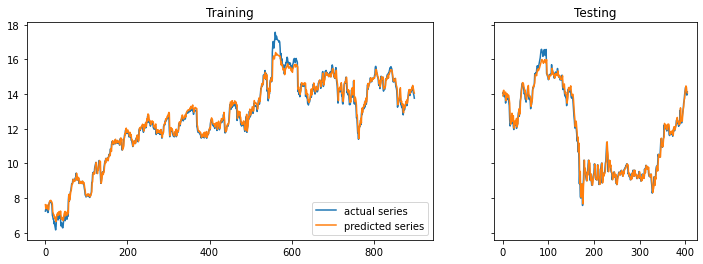

Waktu untuk training (dengan 400 epochs) dan prediksi:  0:00:50.072304


In [45]:
#Parameters w0, w1 dan w2 sebagai ilmu pengetahuan atau knowledge yang diperoleh selama training 
#akan digunakan disini untuk di-test kemampuannya memprediksi. 
#Data yang dipakai Xtest dan ytest yang tidak digunakan selama training.

Cost_train = ann2.Cost    #Ini untuk data untuk training

ann2.prediction(Xtest,ytest)   #Gunakan data untuk test
predicted_ytest = ann2.predicted_y
Cost_test = ann2.Cost          #Ini dengan data untuk test 

print('\nMSE training: %8.7f'%Cost_train,'\nMSE testing : %8.7f'%Cost_test)

ytesto    = ytest*(Bmax-Bmin)+Bmin      #Kembalikan datanya ke original unit dalam satuan dolar
ytesthato = predicted_ytest*(Bmax-Bmin)+Bmin   #Kembalikan datanya ke original unit dalam satuan dolar

# Plot
wr1 = int(900/len(x)*10)
wr2 = int((len(x)-900)/len(x)*10)
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 4), gridspec_kw={'width_ratios': [wr1, wr2]})

ax[0].set_title('Training')
ax[0].plot(ytrain, label = 'actual series')
ax[0].plot(ytrainhat, label = 'predicted series')
ax[1].set_title('Testing')
ax[1].plot(ytesto, label='actual series')
ax[1].plot(ytesthato, label='predicted series')
ax[0].legend(loc='lower right')
plt.show()

toc = datetime.now()

print(f'Waktu untuk training (dengan {epochs} epochs) dan prediksi: ',  toc-tic)

#### Penyimpanan Model Deep Learning

>Yang dimaksudkan dengan penyimpanan model disini adalah penyimpanan parameters sebagai akumulasi ilmu pengetahuan atau knowledge yang diperoleh mesin selama training untuk kelak digunakan lagi untuk memprediksi harga saham bila kelak di masa yang akan datang ada penambahan data baru di Xtest. 
>
>Penambahan data baru di Xtest bisa berasal dari prediksi sebelumnya sehingga kita bisa menggunakan model untuk memperediksi beberapa perioda ke depan. Data baru yang berasal dari hasil prediksi sebelumnya tentu saja akan membawa serta kesalahan-kesalahan prediksi sebelumnya. Kesalahan prediksi akan akumulatif sehingga disarankan untuk tidak terlalu jauh memprediksi ke depan, hanya beberapa hari saja.

In [21]:
"Proses penyimpanan model:"

#Parameters w dan b dijadikan satu list dalam params
params = [ann2.w, ann2.b]

#Simpan params di dalam IntelModel.dat di komputer
pickle.dump(params, open("MandiriModel.dat", "wb"))  #Penyimpanan model parameters, wb: write binary data

#Diasumsikan sudah ada tambahan data baru Xtest maka langkah prediksi harga saham mirip seperti 
#yang dilakukan di atas. Tambahan data baru bisa pula berasal dari hasil prediksi sebelumnya 
#bila mau dilakukan prediksi yang iteratif.

#Caranya, panggil lagi paramaters dari model Deep Learning:

#### Pemanggilan dan penggunaan Model Deep Learning oleh pihak lain
>Model Deep Learning akan dipanggil dan digunakan untuk forecasting

In [ ]:
"Proses pemanggilan model"
pars = pickle.load(open("MandiriModel.dat", "rb"))  #rb: read binary data
w = pars[0]
b = pars[1]
nlayers = len(w)

"Forward propagation (perambatan maju)"
    
Z, A = [], [Xtest]
        
"Dimulai dari Hidden layers"
for j in arange(len(hlayers)):   #hanya hidden layers
    Z.append(linear(A[j],w[j],b[j]))  #Reaksi kimia di layer ke (j + 1)
    A.append(tanh(Z[j]))     #Aliran listrik di layer ke (j + 1)
        
"Output layer"
Z.append(linear(A[nlayers-1],w[nlayers-1],b[nlayers-1]))  #Reaksi kimia di output layer
A.append(sigmoid(Z[nlayers-1]))
    
predicted_ytest = A[nlayers]
e         = ytest-predicted_ytest
Cost_test = e.T@e/len(ytest)  #mean squared error

#ann2.prediction(Xtest,ytest)   #Gunakan data untuk test
#ytesthat = ann2.predicted_y
#Cost_test = ann2.Cost          #Ini dengan data untuk test 

print('')
print('MSE training: %8.7f'%Cost_train,'\nMSE testing : %7.7f'%Cost_test)

"Kembalikan datanya ke original unit dalam satuan dolar"
ytesto = ytest*(Bmax-Bmin)+Bmin       
ytesthato = predicted_ytest*(Bmax-Bmin)+Bmin 

plt.plot(ytesto, label = 'actual series')
plt.plot(ytesthato, label = 'predicted series')
plt.legend()
plt.show()